ML Course, Bogotá, Colombia  (&copy; Josh Bloom; June 2019)

In [1]:
%run ../talktools.py

# Learning on Sequences

Time series data (e.g., from sensors) and text are classic examples of sequential data types. 

We saw in the first lecture how to featurize time series and natural language. We saved the features from our TF-IDF work on the dual newsgroup classification challenge. Let's reload that now and learn a model.

In [2]:
import numpy as np
data = np.load("../1_ComputationalAndInferentialThinking/tfidf.npz")
X = data["X"]
y = data["y"]

print(f"Baseline accuracy from random guessing: {y.sum()/len(y):0.3f}")

Baseline accuracy from random guessing: 0.500


In [3]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

# 3 choices of mtry
parameters = {'n_estimators':[100],  'max_features':[5, 8,10,'auto'], 
                        'criterion': ['gini','entropy']}

rf_tune = model_selection.GridSearchCV(RandomForestClassifier(), parameters, 
                                   n_jobs = -1, cv = 5,verbose=1)
rf_opt = rf_tune.fit(X, y)

print("Best zero-one score: " + str(rf_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(rf_opt.best_estimator_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.8s finished


Best zero-one score: 0.8567818028643639

Optimal Model:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


As noted in that first lecture, TF-IDF tends to remove the context that words appear in sentences and with respect to each other.  BoW and TF-IDF features also tend to be sparse making them more challenging, in general, to learn on. One way to make text feature dense (instead of sparse) is using **hashing**.

> In machine learning, feature hashing, also known as the hashing trick...is a fast and space-efficient way of vectorizing features, i.e. turning arbitrary features into indices in a vector or matrix. It works by applying a hash function to the features and using their hash values as indices directly, rather than looking the indices up in an associative array. -- Wikipedia

See also https://arxiv.org/abs/1805.08539

In [39]:
strings = ["Columbia", "Bogotá", "Python", "Python ", "python"]

table_hash_size = 10

hash_table = np.zeros(shape=(table_hash_size,))

for s in strings:
    print(f"hash of {s} = {hash(s)}...modulo {table_hash_size} = {hash(s) % table_hash_size}")
    hash_table[hash(s) % table_hash_size] += 1
    
print(f"Feature hash: {hash_table}")

hash of Columbia = -7264996315615642198...modulo 10 = 2
hash of Bogotá = -5120830709618511812...modulo 10 = 8
hash of Python = 6261257497765767755...modulo 10 = 5
hash of Python  = -6659688031332109028...modulo 10 = 2
hash of python = -1331636320712325309...modulo 10 = 1
Feature hash: [0. 1. 2. 0. 0. 1. 0. 0. 1. 0.]


In [63]:
from sklearn.datasets import fetch_20newsgroups
news_train = fetch_20newsgroups(subset='train', categories=['sci.space','rec.autos'], data_home='datatmp/')

> This class turns sequences of symbolic feature names (strings) into `scipy.sparse matrices`, using a hash function to compute the matrix column corresponding to a name. The hash function employed is the signed 32-bit version of Murmurhash3.

In [76]:
from sklearn.feature_extraction import FeatureHasher
import re

def tokens(doc):
    """Extract tokens from doc.

    This uses a simple regex to break strings into tokens. .
    """
    return (tok.lower() for tok in re.findall(r"\w+", doc))


h = FeatureHasher(n_features=10, input_type='string')
f = h.transform([tokens(x) for x in news_train.data])
f.toarray()

array([[ 6.,  2.,  0., ...,  0.,  8., -6.],
       [ 6., 13.,  3., ..., -4.,  3., -2.],
       [ 6., -1.,  5., ..., -1., -9.,  3.],
       ...,
       [ 4., -2.,  6., ..., -2.,  0., -2.],
       [ 0., -2.,  3., ..., -2.,  2., -4.],
       [ 3.,  1.,  0., ..., -6., -3.,  2.]])

In [78]:
f.shape  # 1187 documents, 10 features

(1187, 10)

In [81]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50)
clf.fit(f, news_train.target)

# make predictions for testing set
pred_rf = clf.predict(f) 
print(pred_rf)
print(news_train.target)

[1 0 0 ... 1 0 0]
[1 0 0 ... 1 0 0]


In [82]:
# compute zero-one loss / score & confusion matrix
from sklearn import metrics

rf_01 = metrics.zero_one_loss(news_train.target, pred_rf) # zero-one loss
rf_01_score = metrics.accuracy_score(news_train.target, pred_rf) # zero-one score
rf_confmat = metrics.confusion_matrix(news_train.target, pred_rf) # conf mat

print("Zero-One Loss: " + str(rf_01))
print("Zero-One Score: " + str(rf_01_score))
print("Confusion Matrix:")
print("[i, j] is the # of objects truly in group i but predicted to be in group j")
print(rf_confmat)

Zero-One Loss: 0.0
Zero-One Score: 1.0
Confusion Matrix:
[i, j] is the # of objects truly in group i but predicted to be in group j
[[594   0]
 [  0 593]]


This is a very nice way of taking what could be a large dimensional feature space and making it more compact. We still are interesting in understand how we might use the context surrounding words to get a more nuianced and predictive **embedding**.

> Count-based methods compute the statistics of how often some word co-occurs with its neighbor words in a large text corpus, and then map these count-statistics down to a small, dense vector for each word. Predictive models directly try to predict a word from its neighbors in terms of learned small, dense embedding vectors (considered parameters of the model). -- https://www.tensorflow.org/tutorials/representation/word2vec

<img src="https://cdn-images-1.medium.com/max/1600/1*Yb-ex-FKu3YBv46XMG2xcA@2x.png">

Learning this model will try to make words that are similar have a similar output (embedding) vector.


> Word2vec, introduced in Distributed Representations of Words and Phrases and their Compositionality (Mikolov et al., NIPS 2013), has attracted a lot of attention in recent years due to its efficiency to produce relevant word embeddings (i.e. vector representations of words). Word2vec is a shallow neural network trained on a large text corpus. The meaning of a word is learned from its surrounding words in the sentences and encoded in a vector of real values.  -- https://www.kernix.com/blog/similarity-measure-of-textual-documents_p12

`spacy` has pretrained models that turn tokens into vectors, trained off of a large corpus from the internet.

In [84]:
# optional: this will take awhile the first time -- it's 0.83 GB in size!
# !python -m spacy download en_core_web_lg

In [103]:
import en_core_web_lg
nlp = en_core_web_lg.load()

In [104]:
token = nlp(u'dog')

In [105]:
token.vector.shape

(300,)

Because we have a 300-length vector, we can ask what the angle is between vectors (cosine similarity):

In [106]:
tokens = nlp(u'dog cat banana')

for token1 in tokens:
    for token2 in tokens:
        print(token1.text, token2.text, token1.similarity(token2))

dog dog 1.0
dog cat 0.8016855
dog banana 0.24327648
cat dog 0.8016855
cat cat 1.0
cat banana 0.28154367
banana dog 0.24327648
banana cat 0.28154367
banana banana 1.0


In [113]:
king = nlp(u'king')
queen = nlp(u'queen')
man = nlp(u'man')
woman = nlp(u'woman')

from scipy import spatial
spatial.distance.cosine(king.vector - man.vector + woman.vector, queen.vector)

0.21191561222076416

<img src="http://jalammar.github.io/images/word2vec/queen-woman-girl-embeddings.png">

<img src="http://jalammar.github.io/images/word2vec/king-analogy-viz.png">

In [118]:
target = nlp("Ponies are beautiful animals.")
 
doc1 = nlp("Horses are amazing.")
doc2 = nlp("Dogs are barking animals.")
doc3 = nlp("Pirarucu, fish from the Amazon, taste great.")
 
print(target.similarity(doc1))  # 0.908860751681014
print(target.similarity(doc2))  # 0.8266815698382363
print(target.similarity(doc3))  # 0.6792794979241238

0.908860751681014
0.8266815698382363
0.6792794979241238


Talk on word2vec https://www.slideshare.net/ChristopherMoody3/word2vec-lda-and-introducing-a-new-hybrid-algorithm-lda2vec-57135994


https://github.com/sdimi/average-word2vec/blob/master/notebook.ipynb

Doc2vec on newsgroups: https://github.com/skillachie/nlpArea51/tree/master/doc2vec

## Timeseries 

We can think of understanding timeseries data in the context of convolutions.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

629


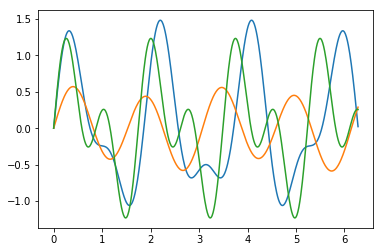

In [2]:
# here's a way to generate some 1D sources with some structure
# set by just a few parameters
def gen_timeseries(ts, period, harmonic_phase_amplitudes):
    timeseries = np.zeros(ts.shape)
    for i, (amp, phase) in enumerate(harmonic_phase_amplitudes):
        timeseries += amp*np.sin(  ((i+1)*period + phase)*ts)
    return timeseries

ts = np.arange(0, 2*np.pi, 0.01)
n_ts = len(ts)

plt.plot(ts, gen_timeseries(ts, 3, [(1.0, 0.5), (0.5, 0.5)]))
plt.plot(ts, gen_timeseries(ts, 2, [(0.1, 0), (0.5, 0.1)]))
plt.plot(ts, gen_timeseries(ts, 3.5, [(0.7, 0.1), (0.7, 0.2)]))
print(n_ts)

In [3]:
from itertools import chain
## make some training data
rnd = np.random.RandomState(seed=42)

n_training = 2000
n_testing = 500

P_training = rnd.rand(n_training)*9 + 1 # make periods from 1-10
ap = rnd.rand(n_training, 4)
ap[:, 1] *= 2*np.pi
ap[:, 3] *= 2*np.pi
spl = np.hsplit(ap, 2)
ampp = [[tuple(spl[0][i, :]), tuple(spl[1][i, :])] for i in range(n_training)]

X_train = []
y_train = []
for i in range(n_training):
    X_train.append(gen_timeseries(ts, P_training[i], ampp[i]))
    y_train.append([P_training[i]] + list(chain(*ampp[i])))

X_train = np.array(X_train)
y_train = np.array(y_train)

# Testing 

P_testing = rnd.rand(n_testing)*9 + 1 # make periods from 1-10
ap = rnd.rand(n_testing, 4)
ap[:, 1] *= 2*np.pi
ap[:, 3] *= 2*np.pi
spl = np.hsplit(ap, 2)
ampp = [[tuple(spl[0][i, :]), tuple(spl[1][i, :])] for i in range(n_testing)]

X_test = []
y_test = []
for i in range(n_testing):
    X_test.append(gen_timeseries(ts, P_testing[i], ampp[i]))
    y_test.append([P_testing[i]] + list(chain(*ampp[i])))

X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
#y_train = np.expand_dims(y_train, axis=2)
#y_test = np.expand_dims(y_test, axis=2)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2000, 629, 1)
X_test shape: (500, 629, 1)
y_train shape: (2000, 5)
y_test shape: (500, 5)


/Users/jbloom/anaconda3/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[9.55642876 0.27194973 4.77144    0.44973984 4.88021636]')

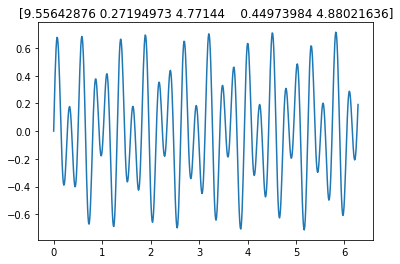

In [4]:
plt.plot(ts, X_train[1, :, 0])
plt.title(y_train[1])

One way to think about this challenge with time series classification is as a 1-D convolution.

In [5]:
from tensorflow.keras.models import Sequential  # linear stack of layers
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, AveragePooling1D


model = Sequential()
model.add(Convolution1D(filters=64, kernel_size=2, input_shape=(n_ts, 1), padding="same"))
model.add(Activation('relu'))
model.add(AveragePooling1D(pool_size=2))

model.add(Convolution1D(filters=32, kernel_size=2, padding="same"))
model.add(Activation('relu'))
model.add(AveragePooling1D(pool_size=2))

model.add(Convolution1D(filters=16, kernel_size=2, padding="same"))
model.add(Activation('relu'))
model.add(AveragePooling1D(pool_size=2))

model.add(Flatten())
model.add(Dropout(0.1)) # helps control overfitting
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_test.shape[1]))
model.add(Activation('linear'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 629, 64)           192       
_________________________________________________________________
activation (Activation)      (None, 629, 64)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 314, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 314, 32)           4128      
_________________________________________________________________
activation_1 (Activation)    (None, 314, 32)           0         
_________________________________________________________________
average_pooling1d_1 (Average (None, 157, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 157, 16)           1

In [8]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='mse', optimizer=Adam(), metrics=['mae', 'mse'])

In [9]:
model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1)

Epoch 1/150
2000/2000 [==============================] - 1s 599us/sample - loss: 10.6072 - mae: 2.4809 - mse: 10.6072
Epoch 2/150
2000/2000 [==============================] - 1s 467us/sample - loss: 6.5373 - mae: 2.2259 - mse: 6.5373
Epoch 3/150
2000/2000 [==============================] - 1s 446us/sample - loss: 5.2948 - mae: 2.0120 - mse: 5.2948
Epoch 4/150
2000/2000 [==============================] - 1s 550us/sample - loss: 4.4906 - mae: 1.8700 - mse: 4.4906
Epoch 5/150
2000/2000 [==============================] - 1s 446us/sample - loss: 3.8425 - mae: 1.7336 - mse: 3.8425
Epoch 6/150
2000/2000 [==============================] - 1s 446us/sample - loss: 3.2719 - mae: 1.5889 - mse: 3.2719
Epoch 7/150
2000/2000 [==============================] - 1s 487us/sample - loss: 2.7738 - mae: 1.4431 - mse: 2.7738
Epoch 8/150
2000/2000 [==============================] - 1s 455us/sample - loss: 2.3602 - mae: 1.3068 - mse: 2.3602
Epoch 9/150
2000/2000 [==============================] - 1s 516us/samp

2000/2000 [==============================] - 1s 461us/sample - loss: 0.9828 - mae: 0.6754 - mse: 0.9828
Epoch 72/150
2000/2000 [==============================] - 1s 411us/sample - loss: 0.9853 - mae: 0.6769 - mse: 0.9853
Epoch 73/150
2000/2000 [==============================] - 1s 437us/sample - loss: 0.9909 - mae: 0.6824 - mse: 0.9909
Epoch 74/150
2000/2000 [==============================] - 1s 398us/sample - loss: 0.9696 - mae: 0.6724 - mse: 0.9696
Epoch 75/150
2000/2000 [==============================] - 1s 478us/sample - loss: 0.9577 - mae: 0.6694 - mse: 0.9577
Epoch 76/150
2000/2000 [==============================] - 1s 529us/sample - loss: 0.9584 - mae: 0.6672 - mse: 0.9584
Epoch 77/150
2000/2000 [==============================] - 1s 408us/sample - loss: 0.9608 - mae: 0.6694 - mse: 0.9608
Epoch 78/150
2000/2000 [==============================] - 1s 439us/sample - loss: 0.9575 - mae: 0.6706 - mse: 0.9575
Epoch 79/150
2000/2000 [==============================] - 1s 480us/sample - l

2000/2000 [==============================] - 1s 500us/sample - loss: 0.7402 - mae: 0.5795 - mse: 0.7402
Epoch 141/150
2000/2000 [==============================] - 1s 514us/sample - loss: 0.7406 - mae: 0.5739 - mse: 0.7406
Epoch 142/150
2000/2000 [==============================] - 1s 507us/sample - loss: 0.7063 - mae: 0.5666 - mse: 0.7063
Epoch 143/150
2000/2000 [==============================] - 1s 515us/sample - loss: 0.7251 - mae: 0.5719 - mse: 0.7251
Epoch 144/150
2000/2000 [==============================] - 1s 507us/sample - loss: 0.7202 - mae: 0.5699 - mse: 0.7202
Epoch 145/150
2000/2000 [==============================] - 1s 486us/sample - loss: 0.7129 - mae: 0.5684 - mse: 0.7129
Epoch 146/150
2000/2000 [==============================] - 1s 485us/sample - loss: 0.7247 - mae: 0.5715 - mse: 0.7247
Epoch 147/150
2000/2000 [==============================] - 1s 480us/sample - loss: 0.7163 - mae: 0.5679 - mse: 0.7163
Epoch 148/150
2000/2000 [==============================] - 1s 472us/sa

In [10]:
pred = model.predict(X_test)

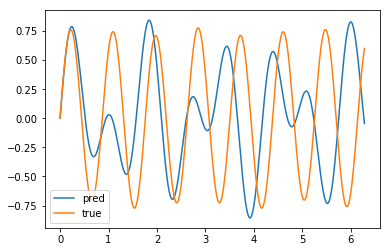

In [11]:
ind = 2
plt.plot(ts, gen_timeseries(ts, pred[ind][0],  [(pred[ind][1],pred[ind][2]), (pred[ind][3],pred[ind][4])]), label="pred")
plt.plot(ts, gen_timeseries(ts, y_test[ind][0],  [(y_test[0][1],y_test[0][2]), (y_test[0][3],y_test[0][4])]), label="true")
plt.legend()

Text(0, 0.5, 'Predicted period')

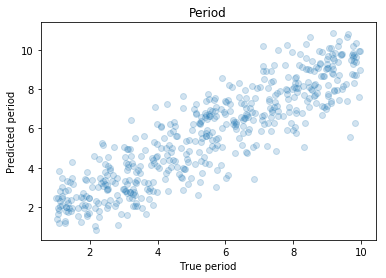

In [12]:
plt.scatter(P_testing, pred[:,0], alpha=0.2)
plt.title("Period")
plt.xlabel("True period")
plt.ylabel("Predicted period")

Text(0, 0.5, 'Predicted A')

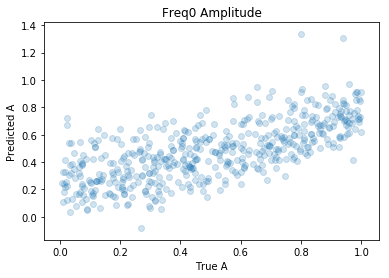

In [13]:
plt.scatter(y_test[:, 1], pred[:,1], alpha=0.2)
plt.title("Freq0 Amplitude")
plt.xlabel("True A")
plt.ylabel("Predicted A")

Text(0, 0.5, 'Predicted Phase')

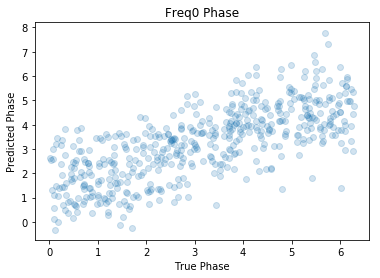

In [14]:
plt.scatter(y_test[:, 2], pred[:,2], alpha=0.2)
plt.title("Freq0 Phase")
plt.xlabel("True Phase")
plt.ylabel("Predicted Phase")

One of the difficulties with this is that convolutions don't easily contemplate the sequential nature of the data. We basically treated the first data point in the same way as the last data point. There are specific layers, called **recurrent neural networks** (RNNs), that handle the sequential nature of the input data (originally developed for language models). 

<img src="https://mlalgorithm.files.wordpress.com/2016/08/rnn1.jpg">

A particular flavor of RNNs called LSTM (Long Short-Term Memory):

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png">

In [42]:
from tensorflow.keras.layers import LSTM, Dropout

> One difficulty when training LSTM with the full gradient is that the derivatives sometimes become excessively large, leading to numerical problems. To prevent this, [we] clipped the derivative of the loss with respect to the network inputs to the LSTM layers (before the sigmoid and tanh functions are applied) to lie within a predefined range. — Generating Sequences With Recurrent Neural Networks, 2013.

In [47]:
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(LSTM(128, input_shape=(n_ts, 1), activation='linear', 
                              return_sequences=True))
model.add(LSTM(128))
model.add(Dense(10, activation='relu'))
model.add(Dense(y_test.shape[1], activation="linear"))

In [48]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 629, 128)          66560     
_________________________________________________________________
lstm_22 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_27 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 55        
Total params: 199,489
Trainable params: 199,489
Non-trainable params: 0
_________________________________________________________________


In [49]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='mse', optimizer=Adam(clipnorm=0.001, clipvalue=0.001), metrics=['mae', 'mse'])

In [50]:
model.fit(X_train, y_train, batch_size=128, epochs=2, verbose=1)

Epoch 1/5
2000/2000 [==============================] - 34s 17ms/sample - loss: nan - mae: nan - mse: nan
Epoch 2/5
 128/2000 [>.............................] - ETA: 30s - loss: nan - mae: nan - mse: nan

KeyboardInterrupt: 

<img src="http://karpathy.github.io/assets/rnn/diags.jpeg">
Source: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

RNN models are very fickle to train (exploding gradients, large amount of RAM, slow!). Temporal Convolutional Neutral nets are convnets that preserve causality. See https://github.com/philipperemy/keras-tcn

<img src="https://github.com/philipperemy/keras-tcn/raw/master/misc/Dilated_Conv.png">